# TensorFlow Crash Course 

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/ok-transformer/blob/master/docs/nb/notes/tf-course.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/ok-transformer?style=social)](https://github.com/particle1331/ok-transformer)

---

**Readings:**  {cite}`RaschkaMirjalili2019` [[Keras API docs](https://keras.io/api/)]

## Introduction

This notebook covers TF datasets, creating and training models with Keras, and internals such as static graphs and auto-differentiation using `GradientTape`. We also look into custom functionality such as modifying the train and eval step of the Keras `fit` function. A basic understanding of neural networks is assumed.

In [1]:
import os
import warnings
from pathlib import Path

import tensorflow as tf
import tensorflow.keras as kr
import tensorflow_datasets as tfds

import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline


def set_random_seed(seed=0, deterministic=False):
    tf.keras.utils.set_random_seed(seed)
    if deterministic:
        tf.config.experimental.enable_op_determinism()


DATASET_DIR = Path("./data").absolute()
RANDOM_SEED = 42

warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats("svg")
set_random_seed(seed=RANDOM_SEED)

print(tf.__version__)
print(tf.config.list_physical_devices("GPU"))

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

## TF Datasets

TensorFlow provides the `tf.data.Dataset` API to facilitate efficient pipelines which support batching, shuffling, and mapping for loading and lazy preprocessing of input data. We can initialize a TF dataset from an existing tensor as follows:

In [3]:
a = tf.range(5)
ds = tf.data.Dataset.from_tensor_slices(a)
print(ds, "\n")

for item in ds:
    print(item)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)> 

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


### Batching

Datasets supports **batching** of multiple tensors:

In [4]:
X = tf.random.uniform([10, 3], dtype=tf.float32)
y = tf.range(10)

ds = tf.data.Dataset.from_tensor_slices((X, y))
for x, t in ds.batch(3, drop_remainder=True):
    print(pd.DataFrame({
        "X1": x.numpy()[:, 0],
        "X2": x.numpy()[:, 1], 
        "X3": x.numpy()[:, 2], 
        "y": t.numpy()
    }), "\n")

         X1        X2        X3  y
0  0.664562  0.441007  0.352883  0
1  0.464483  0.033660  0.684672  1
2  0.740117  0.872445  0.226326  2 

         X1        X2        X3  y
0  0.223197  0.310388  0.722336  3
1  0.133187  0.548064  0.574609  4
2  0.899683  0.009464  0.521231  5 

         X1        X2        X3  y
0  0.634544  0.199328  0.729422  6
1  0.545835  0.107566  0.676706  7
2  0.660276  0.336950  0.601418  8 



Dropping the remainder ensures all batches are of equal size.

### Transformations

Batch transformation can be done using `map`. 
This also returns a `Dataset` object:

In [5]:
T = lambda x, y: (10 * x - 3, y)
dst = ds.map(T)
for x, y in dst.batch(3):
    print(pd.DataFrame({
        "X1": x.numpy()[:, 0],
        "X2": x.numpy()[:, 1], 
        "X3": x.numpy()[:, 2], 
        "y":  y.numpy()
    }), "\n")

         X1        X2        X3  y
0  3.645621  1.410068  0.528825  0
1  1.644825 -2.663396  3.846724  1
2  4.401175  5.724445 -0.736737  2 

         X1        X2        X3  y
0 -0.768031  0.103881  4.223358  3
1 -1.668128  2.480639  2.746088  4
2  5.996835 -2.905363  2.212307  5 

         X1        X2        X3  y
0  3.345445 -1.006717  4.294225  6
1  2.458345 -1.924345  3.767061  7
2  3.602763  0.369504  3.014176  8 

         X1        X2        X3  y
0 -0.893742  5.527372  1.406218  9 



**Remark.** Various optimizations such as **prefetching**, **parallelism** ({numref}`tf-parallel_map`), and **caching** exist for TF datasets. See [TF docs](https://www.tensorflow.org/guide/data_performance). For example, the above map is inefficient since it applies the map on at a time instead of vectorized through a batch.


```{figure} ../../img/tf-parallel_map.svg
---
name: tf-parallel_map
width: 80%
---
Pre-pocessing steps overlap, reducing the overall time for a single iteration. [Source](https://www.tensorflow.org/guide/data_performance)
```

### Shuffle

It is important to feed training data as randomly shuffled batches when training with SGD. Otherwise, the weight updates will be biased with regards to ordering of the input data. TensorFlow implements the `.shuffle` method on dataset objects with a `buffer_size` parameter for controlling the chunk size. This results in a tradeoff between shuffle quality and memory.

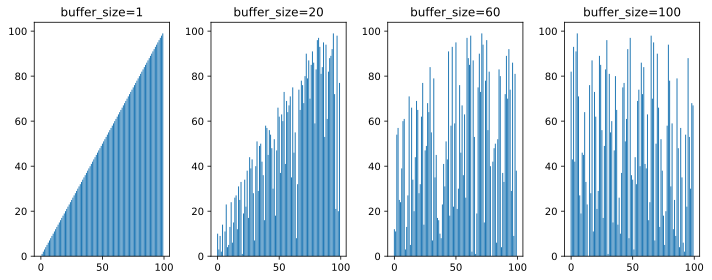

In [6]:
fig = plt.figure(figsize=(10, 4))
buffer_size = [1, 20, 60, 100]
for i in range(len(buffer_size)):
    shuffled_data = []
    ds_range = tf.data.Dataset.from_tensor_slices(tf.range(100))
    for x in ds_range.shuffle(buffer_size[i]).batch(1):
        shuffled_data.append(x.numpy()[0])

    ax = fig.add_subplot(1, 4, i+1)
    ax.bar(range(100), shuffled_data)
    ax.set_title(f"buffer_size={buffer_size[i]}")

plt.tight_layout()
plt.show()

A `buffer_size` of 1 is essentially the same dataset, while a `buffer_size` equal to the length of the dataset is a full shuffle. Note that the `.shuffle` returns a `ShuffleDataset` and has the argument `reshuffle_each_iteration` which defaults to `True`. This means that the resulting dataset reshuffles each time we iterate over it.

In [7]:
ds = tf.data.Dataset.range(3)
list(ds.shuffle(3).repeat(2).as_numpy_iterator())

[1, 2, 0, 2, 1, 0]

Setting it to `False` means that it is shuffled once, then it is fixed over iterations:

In [8]:
ds = tf.data.Dataset.range(3)
list(ds.shuffle(3, reshuffle_each_iteration=False).repeat(2).as_numpy_iterator())

[1, 2, 0, 1, 2, 0]

### Creating epochs

The **shuffle**, **batch**, **repeat** pattern generates epochs for neural network training:

In [9]:
num_epochs = 2
batch_size = 3
buffer_size = 6
for i in range(num_epochs):
    for x, t in dst.shuffle(buffer_size).batch(batch_size, drop_remainder=True):
        print(pd.DataFrame({
            "X1": x.numpy()[:, 0],
            "X2": x.numpy()[:, 1], 
            "X3": x.numpy()[:, 2], 
            "y": t.numpy()
        }), "\n")

         X1        X2        X3  y
0  5.996835 -2.905363  2.212307  5
1 -0.768031  0.103881  4.223358  3
2  3.345445 -1.006717  4.294225  6 

         X1        X2        X3  y
0 -1.668128  2.480639  2.746088  4
1  4.401175  5.724445 -0.736737  2
2  3.602763  0.369504  3.014176  8 

         X1        X2        X3  y
0  3.645621  1.410068  0.528825  0
1  2.458345 -1.924345  3.767061  7
2  1.644825 -2.663396  3.846724  1 

         X1        X2        X3  y
0  1.644825 -2.663396  3.846724  1
1  3.345445 -1.006717  4.294225  6
2 -1.668128  2.480639  2.746088  4 

         X1        X2        X3  y
0  3.602763  0.369504  3.014176  8
1 -0.893742  5.527372  1.406218  9
2 -0.768031  0.103881  4.223358  3 

         X1        X2        X3  y
0  2.458345 -1.924345  3.767061  7
1  4.401175  5.724445 -0.736737  2
2  3.645621  1.410068  0.528825  0 



### From local files

Transformations can be used with any user-defined function. For example, we can load data from disk by creating a TF dataset of filenames. Then, we can define a map that loads the files from disk:

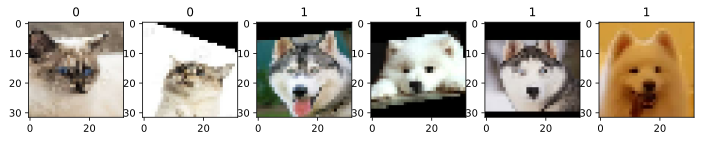

In [11]:
from functools import partial

# Define mapping function: (filename, label) -> (RGB array, label)
def load_and_preprocess(path, label, img_width=124, img_height=124):
    img_raw = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img_raw, channels=3)
    img = tf.image.resize(img, [img_height, img_width])
    img /= 255.0
    return img, label


# File list
DATASET_DIR = Path("./tf-course/data").absolute()
cat_path = DATASET_DIR / "cat2dog" / "cat2dog" / "trainA"
dog_path = DATASET_DIR / "cat2dog" / "cat2dog" / "trainB"
cat_files = sorted([str(path) for path in cat_path.glob("*.jpg")])
dog_files = sorted([str(path) for path in dog_path.glob("*.jpg")])

# Create dataset of RGB arrays resized to 32x32x3
X = cat_files + dog_files
y = [0] * len(cat_files) + [1] * len(dog_files)
ds_filenames = tf.data.Dataset.from_tensor_slices((X, y))
ds_images = ds_filenames.map(partial(load_and_preprocess, img_width=32, img_height=32))

# Display one image and its label (0 = cat, 1 = dog) 
img, label = next(iter(ds_images.shuffle(len(ds_images)).batch(6)))
fig, ax = plt.subplots(1, 6, figsize=(12, 2))
for i in range(6):
    ax[i].imshow(img[i, :, :, :])
    ax[i].set_title(int(label[i]))

## Mechanics of TF

For advanced deep learning models, we need lower-level features of TensorFlow. This allows accessing and modifying layer weights and gradients, performing autodiff, and creating more efficient static computation graphs from ordinary Python code. This sections takes a brief look into the `@tf.function` decorator and performing autograd (of arbitrary order) with `GradientTape`.

### Static graph execution

Computations with eager execution are not as efficient as the static graph execution which is precompiled. TensorFlow provides a simple mechanism for compiling a normal Python function `f` to a static graph by using `tf.function(f)` or use the `@tf.function` decorator in the definition of `f`.

In [12]:
def f(x, y, z):
    return x + y + z

f_graph = tf.function(f)
tf.print("Scalar Inputs:", f_graph(1, 2, 3))
tf.print("Rank 1 Inputs:", f_graph([1], [2], [3]))
tf.print("Rank 2 Inputs:", f_graph([[1]], [[2]], [[3]]))

Scalar Inputs: 6
Rank 1 Inputs: [1, 2, 3]
Rank 2 Inputs: [[1], [2], [3]]


Here we encounter a first subtlety with static graphs. The above three executions actually create three graphs under the hood. TensorFlow uses a **tracing mechanism** to construct a graph based on the input arguments. For this tracing mechanism, TensorFlow generates a tuple of keys based on the input signatures
given for calling the function. The generated keys are as follows:

* For `tf.Tensor` arguments, the key is based on their shapes and `dtypes`.
* For Python types, such as lists, their `id()` is used to generate cache keys.
* For Python primitive values, the cache keys are based on the input values.

Upon calling a decorated function, TF either retrieves the graph by key or creates one if the key does not exist. Graph creation includes TensorFlow as well as Python operations as nodes. See [here](https://blog.tensorflow.org/2018/07/autograph-converts-python-into-tensorflow-graphs.html) for details. This is not generally an issue in practice where the shape of the input is expected. To limit input signature and types:

In [13]:
f_graph = tf.function(f, input_signature=(
    tf.TensorSpec(shape=[None], dtype=tf.int32),
    tf.TensorSpec(shape=[None], dtype=tf.int32),
    tf.TensorSpec(shape=[None], dtype=tf.int32),
))

f_graph([1], [2], [3])

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([6], dtype=int32)>

In [14]:
try:
    f_graph(1, 2, 3)
except Exception as e:
    print(e)

Python inputs incompatible with input_signature:
  inputs: (
    1,
    2,
    3)
  input_signature: (
    TensorSpec(shape=(None,), dtype=tf.int32, name=None),
    TensorSpec(shape=(None,), dtype=tf.int32, name=None),
    TensorSpec(shape=(None,), dtype=tf.int32, name=None)).


### Timing static graphs

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from timeit import timeit

def compare_timings(f, x, n):
    # Define functions
    eager_function = f
    graph_function = tf.function(f)

    # Timing
    graph_time = timeit(lambda: graph_function(*x), number=n) / n
    eager_time = timeit(lambda: eager_function(*x), number=n) / n
    
    return {
        "graph": graph_time,
        "eager": eager_time
    }

# sample input
u = tf.random.uniform([256, 28, 28])

Comparing static graph execution with eager execution on a dense network:

In [16]:
from tensorflow.keras.layers import Flatten, Dense

model = kr.Sequential()
model.add(Flatten())
model.add(Dense(256, "relu"))
model.add(Dense(10, "softmax"))

dense_times = compare_timings(model, [u], n=10000);

Convolution operation:

In [17]:
from tensorflow.keras.layers import Conv2D, AveragePooling2D

conv_model = kr.Sequential()
conv_model.add(Conv2D(filters=6, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
conv_model.add(Conv2D(filters=6, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
conv_model.add(AveragePooling2D())

conv_times = compare_timings(conv_model, [u], n=10000);

Results:

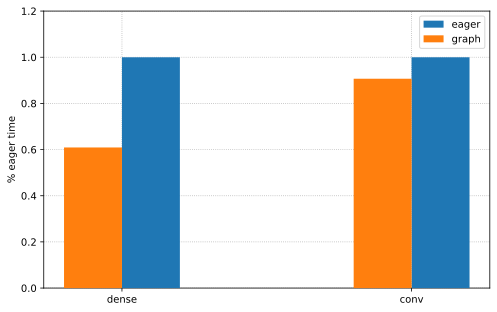

In [18]:
models = ["dense", "conv"]
eager = [eval(m + "_times")["eager"] / eval(m + "_times")["eager"] for m in models]
graph = [eval(m + "_times")["graph"] / eval(m + "_times")["eager"] for m in models]
x = np.arange(len(models))

plt.figure(figsize=(8, 5))
plt.grid(linestyle="dotted", zorder=1)
plt.bar(x + 0.1, eager, width=0.2, label="eager", zorder=3)
plt.bar(x - 0.1, graph, width=0.2, label="graph", zorder=3)
plt.xticks(x, models)
plt.ylabel(r"% eager time")
plt.ylim(0, 1.2)
plt.legend();

The above results (sorted in decreasing no. of parameters) show that graph execution can be faster can be faster than eager code, especially for graphs with expensive operations. But for graphs with fewer expensive operations (like convolutions), you may see little speedup or even worse with cheap operations due to the overhead of tracing.

**Remark.** For example, the following error message highlights cases where we make inefficient use of tracing. Recall the rules above for generating keys for static graphs based on the input. This [guide](https://www.tensorflow.org/guide/function#tracing) on tracing mechanism is also helpful. 

> WARNING:tensorflow:6 out of the last 6 calls to <keras.engine.sequential.Sequential object at 0x28575dfa0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop.

### TF variables

A **variable** maintains shared, persistent state that implements the concept of **model parameter** in TensorFlow. [TF modules](https://www.tensorflow.org/api_docs/python/tf/Module) are essentially named containers for variables and implements a forward method. Below we implement a linear layer in TF:

In [19]:
class MyModule(tf.Module):
    def __init__(self):
        init = kr.initializers.GlorotNormal()
        self.a = tf.Variable(-1.0, trainable=False)
        self.w = tf.Variable(init(shape=(3, 2)), trainable=True)
        self.b = tf.Variable(init(shape=(1, 2)), trainable=True)

    def __call__(self, x):
        return  self.a * x @ self.w + self.b


m = MyModule()
print("All variables:")
[print(v.shape) for v in m.variables]

print("\nTrainable:")
[print(v.shape) for v in m.trainable_variables];

All variables:
()
(1, 2)
(3, 2)

Trainable:
(1, 2)
(3, 2)


Testing call method:

In [20]:
bs = 6
x = tf.random.uniform([bs, 3], dtype=tf.float32)
m(x)

<tf.Tensor: shape=(6, 2), dtype=float32, numpy=
array([[ 0.10170744, -0.2540003 ],
       [ 0.09207833,  0.00356225],
       [ 0.08909164,  0.0276397 ],
       [ 0.04640259, -0.02139331],
       [ 0.10501287, -0.23698108],
       [ 0.15016323, -0.22649907]], dtype=float32)>

Updating variables (see [other ops](https://www.tensorflow.org/api_docs/python/tf/Variable#methods)):

In [21]:
m.w.assign_add(100.0 * tf.ones_like(m.w))
m(x)

<tf.Tensor: shape=(6, 2), dtype=float32, numpy=
array([[-223.61987 , -223.97559 ],
       [ -24.395416,  -24.483934],
       [ -95.51543 ,  -95.57688 ],
       [-107.76779 , -107.83559 ],
       [-215.19844 , -215.54044 ],
       [-131.50824 , -131.8849  ]], dtype=float32)>

### Autograd with `GradientTape`

TensorFlow supports automatic differentiation for operations defined in the language. For nested functions, TF provides a context called `GradientTape` for calculating gradients of these computed tensors with respect to its dependent nodes in the computation graph. This allows TensorFlow to trace the graph forwards to make predictions and [backwards](00-backprop) to compute the weight gradients.

In [22]:
# scope outside tf.GradientTape
w = tf.Variable(1.0)
b = tf.Variable(0.5)

# data
x = tf.convert_to_tensor([1.4])
y = tf.convert_to_tensor([2.1])

with tf.GradientTape() as tape:
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

grad = tape.gradient(loss, w)
tf.print("∂(loss)/∂w =", grad)
tf.print(2 * (y - w*x - b) * (-x)) # symbolic

∂(loss)/∂w = -0.559999764
[-0.559999764]


It turns out that TF supports stacking gradient tapes which allow us to compute higher order derivatives:



In [23]:
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        z = tf.add(tf.multiply(w, x), b)
        loss = tf.reduce_sum(tf.square(y - z))
    grad_w = inner_tape.gradient(loss, w)
grad_wb = outer_tape.gradient(grad_w, b)

tf.print("∂²(loss)/∂w∂b =", grad_wb)
tf.print(2 * (-1) * (-x)) # symbolic

∂²(loss)/∂w∂b = 2.8


[2.8]


For non-trainable variables and other `Tensor` objects, we have to manually add them using `tape.watch()`.

In [24]:
with tf.GradientTape() as tape:
    tape.watch(x) # <-
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

grad = tape.gradient(loss, x)
tf.print("∂(loss)/∂x =", grad)
tf.print(2 * (y - w*x - b) * (-w)) # check symbolic

∂(loss)/∂x = [-0.399999857]
[-0.399999857]


Note that the tape will keep the resources only for a single gradient computation by default. So after calling `tape.gradient()` once, the resources are released. If we want to compute more than one gradient, we need to persist it.

In [25]:
with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

tf.print("∂(loss)/∂w =", tape.gradient(loss, w))
tf.print("∂(loss)/∂x =", tape.gradient(loss, x)) # error if not persisted

∂(loss)/∂w = -0.559999764
∂(loss)/∂x = [-0.399999857]


### SGD step update

During SGD, we are computing gradients of a loss term with respect to model weights, which we use to update the weights according to some rule defined by an optimization algorithm. For Keras optimizers, we can do this by  using `.apply_gradients`:

In [26]:
grad_w = tape.gradient(loss, w)
grad_b = tape.gradient(loss, b)
lr = 0.1
tf.print("w =", w)
tf.print("b =", b)
tf.print("λ =", lr)
tf.print("grad_[w, b] =", [grad_w, grad_b])

# Define keras optimizer; apply optimizer step
optimizer = kr.optimizers.SGD(learning_rate=lr)
optimizer.apply_gradients(zip([grad_w, grad_b], [w, b]))

# Print updates
tf.print()
tf.print("w - λ·∂(loss)/∂w ≟", w)
tf.print("b - λ·∂(loss)/∂b ≟", b)

w = 1
b = 0.5
λ = 0.1
grad_[w, b] = [-0.559999764, -0.399999857]

w - λ·∂(loss)/∂w ≟ 1.056
b - λ·∂(loss)/∂b ≟ 0.539999962


Checks out.

(keras)=
## Model training

Keras provides multiple layers of abstraction to make the implementation of standard architectures very convenient. This allows us to implement custom functionality, such as neural network layers, which is very useful in research projects. The tradeoff with ease of use is that Keras code can be significantly slower due to large overhead. We will explore how to implement more efficient minimal custom training loops.

### How to build your models

```{margin}
**Figure 3.1** from
{cite}`ganegedara2022tensorflow`
```

```{figure} ../../img/keras-models.png
---
name: keras-models
width: 670px
---

Sequential, functional, and sub-classing APIs for creating models.
```

#### Sequential

For models that perform sequential transforms on input data, we typically use `kr.Sequential()`. Layers can then be added using the `add()` method. Alternatively, we can pass a list of Keras layers in the constructor.

In [27]:
model = kr.Sequential()
model.add(Dense(units=16, activation="relu"))
model.add(Dense(units=32, activation="relu"))
model.add(Dense(units=1,  activation="relu"))

# Build model
model.build(input_shape=(None, 4))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                80        
                                                                 
 dense_3 (Dense)             (None, 32)                544       
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________


In [28]:
for v in model.variables:
    print(f"{v.name:20s} {str(v.trainable):7} {v.shape}")

dense_2/kernel:0     True    (4, 16)
dense_2/bias:0       True    (16,)
dense_3/kernel:0     True    (16, 32)
dense_3/bias:0       True    (32,)
dense_4/kernel:0     True    (32, 1)
dense_4/bias:0       True    (1,)


#### Functional

Not all architectures involve sequential transformation. Keras' functional API comes in handy for more complex transformations such as **residual connections**. Observe that the model build adds a new layer called `tf.__operators__.add` under the hood:

In [29]:
# Specify input and output
x = kr.Input(shape=(2,))
f = Dense(units=2, input_shape=(2,), activation="relu")(x)
out = Dense(units=1, activation="sigmoid")(x + f)

# Build model
model = kr.Model(inputs=x, outputs=out)
model.summary() # compile, fit, etc. also works 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 2)            6           ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 2)           0           ['input_1[0][0]',                
 da)                                                              'dense_5[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 1)            3           ['tf.__operators__.add[0][0]'

#### Model class

To have fine-grained control when building more complex models, we can subclass `kr.Model`. This allows us to define `__init__` for initializing model parameters, and the `call` method for defining forward pass. The subclass inherits methods such as `build()`, `compile()`, and `fit()` which means the usual Keras methods work instances of this class.

In [30]:
class MyModel(kr.Model):
    def __init__(self):
        super().__init__()
        self.dense1 = Dense(units=128, activation="tanh")
        self.dense2 = Dense(units=10, activation="sigmoid")

    def call(self, x):
        h1 = self.dense1(x)
        out = self.dense2(h1)
        return out


# Build model and model summary
model = MyModel()
model.build(input_shape=(None, 2))
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             multiple                  384       
                                                                 
 dense_8 (Dense)             multiple                  1290      
                                                                 
Total params: 1,674
Trainable params: 1,674
Non-trainable params: 0
_________________________________________________________________


### Solving the XOR problem

The XOR is the smallest dataset that is not linearly separable (also the most historically interesting relative to its size {cite}`Minsky1969`). Our version of the XOR dataset is generated by adding Gaussian noise to points `(-1, -1)`, `(-1, 1)`, `(1, -1)` and `(1, 1)`. Points generated from `(1, 1)` and `(-1, -1)` will be labeled `1` otherwise `0`. A dataset of size 200 points will be generated with half used for validation.

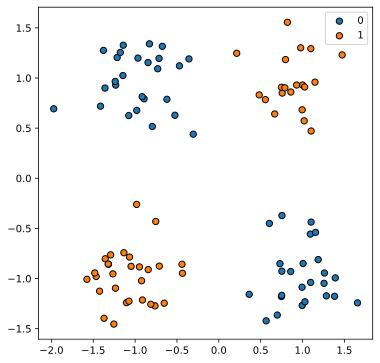

In [31]:
# Create dataset
X = []
Y = []
for p in [(1, 1), (-1, -1), (-1, 1), (1, -1)]:
    x = np.array(p) + np.random.normal(0, 0.3, size=(50, 2)) 
    y = int(p[0] * p[1] > 0) * np.ones(50)
    X.append(x)
    Y.append(y)

X = np.concatenate(X)
Y = np.concatenate(Y)

# Train-test split
indices = list(range(200))
np.random.shuffle(indices)
valid = indices[:100]
train = indices[100:]
X_valid, y_valid = X[valid, :], Y[valid]
X_train, y_train = X[train, :], Y[train]

# Visualize dataset
fig = plt.figure(figsize=(6, 6))
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], s=40, edgecolor="black", label=0)
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], s=40, edgecolor="black", label=1)
plt.legend();

From the geometry of the dataset, we have to use a network that has at least depth 2, so that the network is not a linear classifier. However, since the dataset is small, we want the network to be not too wide (and not too deep), so the model does not overfit the dataset. Our XOR model only has <20 parameters.

In [32]:
model = kr.Sequential()
model.add(kr.layers.Dense(units=4, activation="tanh"))
model.add(kr.layers.Dense(units=1,  activation="sigmoid"))

model.build(input_shape=(None, 2))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 4)                 12        
                                                                 
 dense_10 (Dense)            (None, 1)                 5         
                                                                 
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


**Remark.** The default behavior in Keras is `from_logits=False` where the expected network output are class-probabilities in `[0, 1]` over the number of classes that sum to `1.0`. This can come from a `softmax` activation, though any output is allowed as long as the outputs are class distributions. Here the loss function computes `-log q[k*]` where `q` is the output of the network and `k*` is the index of the true class. Predictions of class label can be obtained using `tf.argmax(q)`. 

```{figure} https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch15/images/15_11.png
---
name: loss-logits-keras
width: 90%
---

Keras API for loss functions. {cite}`RaschkaMirjalili2019` (Chapter 15)
```

Model training:

In [33]:
model.compile(
    optimizer=kr.optimizers.SGD(),
    loss=kr.losses.BinaryCrossentropy(from_logits=False),
    metrics=[kr.metrics.BinaryAccuracy()]
)

hist = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=120,
    batch_size=2, verbose=1
)

Epoch 1/120
50/50 [==============================] - 4s 17ms/step - loss: 0.6812 - binary_accuracy: 0.5700 - val_loss: 0.7189 - val_binary_accuracy: 0.5100
Epoch 2/120
50/50 [==============================] - 1s 12ms/step - loss: 0.6720 - binary_accuracy: 0.6000 - val_loss: 0.7120 - val_binary_accuracy: 0.5500
Epoch 3/120
50/50 [==============================] - 1s 12ms/step - loss: 0.6641 - binary_accuracy: 0.6600 - val_loss: 0.7053 - val_binary_accuracy: 0.6300
Epoch 4/120
50/50 [==============================] - 1s 12ms/step - loss: 0.6562 - binary_accuracy: 0.7300 - val_loss: 0.6990 - val_binary_accuracy: 0.7000
Epoch 5/120
50/50 [==============================] - 1s 12ms/step - loss: 0.6484 - binary_accuracy: 0.7800 - val_loss: 0.6913 - val_binary_accuracy: 0.7000
Epoch 6/120
50/50 [==============================] - 1s 11ms/step - loss: 0.6404 - binary_accuracy: 0.7900 - val_loss: 0.6832 - val_binary_accuracy: 0.7000
Epoch 7/120
50/50 [==============================] - 1s 11ms/ste

In [34]:
hist.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

Note like the `fit` method, Keras also provides an `evaluate` method:

In [35]:
from mlxtend.plotting import plot_decision_regions

def plot_training_history(hist, metric_name):
    _, ax = plt.subplots(1, 3, figsize=(12, 3))

    ax[0].plot(range(120), hist.history["loss"], label="loss (train)")
    ax[0].plot(range(120), hist.history["val_loss"], label="loss (valid)")
    ax[0].legend()

    ax[1].plot(range(120), hist.history[metric_name], label=f"{metric_name} (train)")
    ax[1].plot(range(120), hist.history[f"val_{metric_name}"], label=f"{metric_name} (valid)")
    ax[1].legend();

    ax[2] = plot_decision_regions(X=X_valid, y=y_valid.astype(np.int_), clf=model, legend=2)
    return ax

11250/11250 [==============================] - 24s 2ms/step


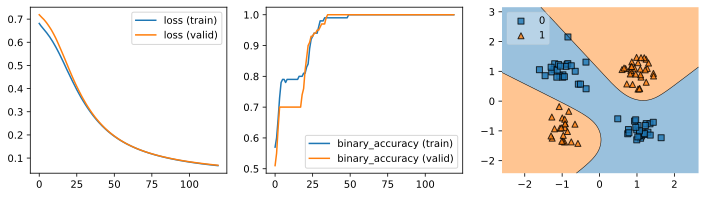

In [36]:
model.evaluate(X_valid, y_valid, batch_size=1)
plot_training_history(hist, "binary_accuracy");

Prediction probability at each point. Note the blurring at the boundaries:

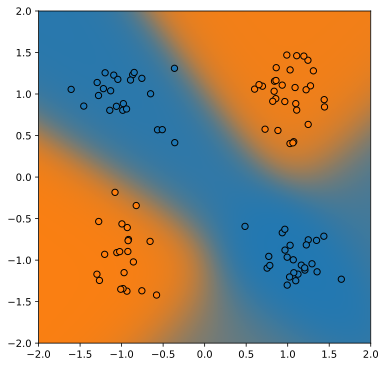

In [37]:
from matplotlib.colors import to_rgba

# Plot valid set points
def plot_decision_gradient(model):
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X_valid[y_valid==0, 0], X_valid[y_valid==0, 1], s=40, edgecolor='black', label=0)
    plt.scatter(X_valid[y_valid==1, 0], X_valid[y_valid==1, 1], s=40, edgecolor='black', label=1)

    # Plot decision gradient
    c0 = np.array(to_rgba("C0"))
    c1 = np.array(to_rgba("C1"))
    x1 = np.arange(-2, 2, step=0.01)
    x2 = np.arange(-2, 2, step=0.01)

    xx1, xx2 = np.meshgrid(x1, x2)
    model_inputs = np.stack([xx1, xx2], axis=-1)
    preds = model(model_inputs.reshape(-1, 2)).numpy().reshape(400, 400, 1)
    out_img = (1 - preds) * c0 + preds * c1 # blending
    plt.imshow((255 * out_img / out_img.max()).astype(np.uint8), origin='lower', extent=(-2, 2, -2, 2));

# Plotting
plot_decision_gradient(model);

## Creating custom layers

Suppose we want to define a layer not supported by Keras or want to customize an existing layer. To do this, we simply inherit from the Keras `Layer` class and define the `__init__()` and `call()` methods. Optional methods are the `build()` method which handles delayed variable initialization and `get_config()` which can be useful for serialization.

**Implementation.** The following layer computes a linear layer with inputs corrupted with noise at train time, i.e. $\boldsymbol{\mathsf{x}} + \boldsymbol{\epsilon}$ passed to a dense layer. This can be thought of as as a form of regularization. During inference the noise is removed so that it becomes equivalent to a usual dense layer. Note that noise is resampled for each input $\boldsymbol{\mathsf x}$ in a batch.

In [38]:
class NoisyLinear(kr.layers.Layer):
    def __init__(self, output_dim, noise_stddev=0.1, **kwargs):
        self.output_dim = output_dim
        self.noise_stddev = noise_stddev
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.w = self.add_weight(
            name="weights", 
            shape=(input_shape[1], self.output_dim),
            initializer="random_normal",
            trainable=True
        )

        self.b = self.add_weight(
            name="bias",
            shape=(self.output_dim,),
            initializer="zeros",
            trainable=True
        )
    
    def call(self, x, training=False):
        if training:
            noise = tf.random.normal(
                shape=x.shape, 
                mean=0.0, 
                stddev=self.noise_stddev
            )
        else:
            noise = tf.zeros_like(x)
        
        z = tf.matmul(x + noise, self.w) + self.b
        return kr.activations.relu(z)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "noise_stddev": self.noise_stddev
        })
        return config

Notice that in the `call()` method there is an additional argument, `training=False`. This distinguishes whether a model or layer is used at training or at inference time. This is automatically set in Keras to `True` when using `.fit` and to `False` when using `.predict`. 
In this case, noise is only added only during training.

In [39]:
noisy_layer = NoisyLinear(output_dim=1)
noisy_layer.build(input_shape=(None, 1))

Testing the `.config` method.

In [40]:
# Re-building from config:
config = noisy_layer.get_config()
new_layer = NoisyLinear.from_config(config)
print(config)

{'name': 'noisy_linear', 'trainable': True, 'dtype': 'float32', 'output_dim': 1, 'noise_stddev': 0.1}


Testing call outside training if noise is zero:

In [41]:
# Zero noise?
tf.math.reduce_sum(noisy_layer(tf.zeros(shape=(100, 1)))).numpy()

0.0

**Remodelling.** Adding `NoisyLinear` to our previous model for XOR. Note that noise should be scaled depending on the magnitude of the input. In our case, the input features vary between $-1$ to $1,$ so we set $\sigma = 0.3$ in the noisy linear for it to have considerable effect.

In [42]:
model = kr.Sequential()
model.add(kr.layers.Dense(units=4, activation="tanh"))
model.add(NoisyLinear(output_dim=4, noise_stddev=0.3))
model.add(kr.layers.Dense(units=1, activation="sigmoid"))

model.build(input_shape=(None, 2))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 4)                 12        
                                                                 
 noisy_linear_1 (NoisyLinear  (None, 4)                20        
 )                                                               
                                                                 
 dense_12 (Dense)            (None, 1)                 5         
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.compile(
    optimizer=kr.optimizers.SGD(),
    loss=kr.losses.BinaryCrossentropy(from_logits=False),
    metrics=[kr.metrics.BinaryAccuracy()]
)

hist = model.fit(
    X_train, y_train, # fit accepts numpy arrays
    validation_data=(X_valid, y_valid),
    epochs=120,
    batch_size=2, verbose=0
)

11250/11250 [==============================] - 27s 2ms/step


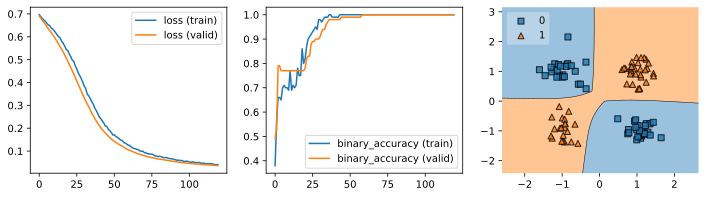

In [44]:
plot_training_history(hist, "binary_accuracy");

Notice that the training curve is noisier than before since we added a large amount of noise.

## Persisting models

Models can be saved and loaded as follows. Note that below we save a compiled model, i.e. the model includes a reference to an optimizer. Setting `include_optimizer=True` also saves the state of the optimizer (e.g. moving averages of the gradients).

In [45]:
model.save("model.h5", 
    overwrite=True, 
    include_optimizer=True,
    save_format="h5"
)

Note that custom layers need to be taken particular care of when loading:

In [46]:
model_load = kr.models.load_model(
    "model.h5", 
    custom_objects={"NoisyLinear": NoisyLinear}
)

model_load.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 4)                 12        
                                                                 
 noisy_linear_1 (NoisyLinear  (None, 4)                20        
 )                                                               
                                                                 
 dense_12 (Dense)            (None, 1)                 5         
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


The network architecture can also be persisted as a JSON object:

In [47]:
import json

json_object = json.loads(model.to_json())
print(json.dumps(json_object, indent=2))

{
  "class_name": "Sequential",
  "config": {
    "name": "sequential_4",
    "layers": [
      {
        "class_name": "InputLayer",
        "config": {
          "batch_input_shape": [
            null,
            2
          ],
          "dtype": "float32",
          "sparse": false,
          "ragged": false,
          "name": "dense_11_input"
        }
      },
      {
        "class_name": "Dense",
        "config": {
          "name": "dense_11",
          "trainable": true,
          "dtype": "float32",
          "units": 4,
          "activation": "tanh",
          "use_bias": true,
          "kernel_initializer": {
            "class_name": "GlorotUniform",
            "config": {
              "seed": null
            }
          },
          "bias_initializer": {
            "class_name": "Zeros",
            "config": {}
          },
          "kernel_regularizer": null,
          "bias_regularizer": null,
          "activity_regularizer": null,
          "kernel_constrai

## Appendix: Keras deep dive

### Metrics

Recall that we specify metrics when compiling models with `model.compile()` where we can pass a list of metrics. Metric values are displayed during `fit()` and logged to the returned history object. They are also computed using `model.evaluate()` on some validation set.

```python
model.compile(
    optimizer="adam",
    loss=kr.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        kr.metrics.Accuracy(),
        kr.metrics.AUC(from_logits=True)
    ]
)
```

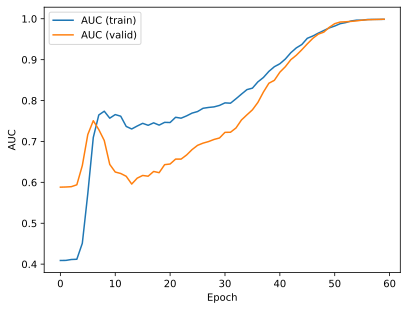

In [48]:
model = kr.Sequential()
model.add(Dense(units=4, input_shape=(2,), activation="tanh"))
model.add(Dense(units=1)) # logits, i.e. pre-sigmoid

model.compile(
    optimizer="adam",
    loss=kr.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        kr.metrics.Accuracy(),
        kr.metrics.AUC(from_logits=True)
    ]
)

hist = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=60,
    batch_size=2, verbose=0
)

plt.plot(hist.history["auc"], label="AUC (train)")
plt.plot(hist.history["val_auc"], label="AUC (valid)")
plt.ylabel("AUC")
plt.xlabel("Epoch")
plt.legend();

Creating custom metrics can be helpful when monitoring model training. Note that metrics are stateful and the base Keras class for this  expects `update_state`, `reset_state`, and `result` methods:

In [49]:
class RootMeanSquaredError(kr.metrics.Metric):
    
    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(
            name="mse_sum", 
            initializer="zeros"
        )
        self.total_samples = self.add_weight(
            name="total_samples", 
            initializer="zeros", dtype="int32"
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        self.total_samples.assign_add(tf.shape(y_pred)[0])

    def result(self):
        N = tf.cast(self.total_samples, tf.float32)
        return tf.sqrt(self.mse_sum / N)

    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

Testing this:

In [50]:
rmse = RootMeanSquaredError()
y_true = tf.constant(np.random.randn(32), dtype=tf.float32)
y_pred = tf.constant(np.random.randn(32), dtype=tf.float32)

rmse.update_state(y_true[:16], y_pred[:16])
print("RMSE:", float(rmse.result()))

rmse.update_state(y_true[16:], y_pred[16:])
print("RMSE:", float(rmse.result()))

actual = float(rmse.result())
expected = tf.sqrt(tf.reduce_sum(tf.square(y_true - y_pred)) / len(y_true)).numpy()
print("error:", tf.abs(actual - expected).numpy())

RMSE: 0.9327664375305176
RMSE: 1.2027475833892822
error: 0.0


### Callbacks API

Callbacks define an [action](https://keras.io/guides/writing_your_own_callbacks/#an-overview-of-callback-methods) on every phase of training, testing, and prediction. Refer to [this guide](https://keras.io/guides/writing_your_own_callbacks) for writing custom callbacks. These are passed as a list on the `callbacks` parameter of the `fit` method of Keras models and the actions are executed accordingly by the Keras API. For example:

```python
checkpoint = kr.callbacks.ModelCheckpoint(
    "xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5", # formatted string
    save_best_only=True, 
    monitor="val_accuracy",
    mode="max"
)
```

Note it does not explicitly say when this callback is called. See [docs](https://keras.io/api/callbacks/model_checkpoint/). For custom callbacks, we have to specify the action for each phase:

```python
class MLflowLoggingCallback(kr.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        mlflow.log_metrics({
            k: logs[k] for k in [
                "loss", 
                "sparse_categorical_accuracy", 
                "val_loss", 
                "val_sparse_categorical_accuracy"
            ]
        })
```


### Training from scratch

In [51]:
import time
import tensorflow_datasets as tfds
import tensorflow as tf


def transform_image(img):
    img = tf.image.per_image_standardization(img)
    img = tf.reshape(img, (-1,))
    return img


def get_fmnist_model():
    model = kr.Sequential([
        Dense(units=256, activation="relu"),
        Dense(units=256, activation="relu"),
        Dense(units=256, activation="relu"),
        Dense(units=10)
    ])
    model.build(input_shape=(None, 784))
    return model


FMNIST, FMNIST_info = tfds.load(
    "fashion_mnist", 
    data_dir="./data", 
    with_info=True, 
    shuffle_files=False
)

train_ds, valid_ds = FMNIST["train"], FMNIST["test"]
f = lambda x: (transform_image(x["image"]), x["label"])
train_ds = train_ds.map(f)
valid_ds = valid_ds.map(f)
print(len(train_ds), len(valid_ds))


def reset_experiment():
    """Reset random seed and data loaders."""

    set_random_seed(RANDOM_SEED, deterministic=False)
    train_loader = train_ds.shuffle(10000).batch(32).prefetch(100)
    valid_loader = valid_ds.batch(32)
    model = get_fmnist_model()

    return {
        "model": model,
        "train_loader": train_loader,
        "valid_loader": valid_loader
    }

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling data/fashion_mnist/3.0.1.incompleteHBRPOI/fashion_mnist-train.tfrecord*...:   0%|          | 0/60000…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling data/fashion_mnist/3.0.1.incompleteHBRPOI/fashion_mnist-test.tfrecord*...:   0%|          | 0/10000 …

Dataset fashion_mnist downloaded and prepared to ./data/fashion_mnist/3.0.1. Subsequent calls will reuse this data.
60000 10000


#### Train and eval steps

Training has two types of steps per epoch: the `train_step` where the model weights and metrics are updated for a single step of gradient descent for each minibatch, and the `eval_step` which evaluates the metrics over the hold-out dataset at the end of the epoch. Objects which persist throughout the training process such as loss functions, metrics, and optimizer are defined in the outer scope.

In [52]:
from copy import deepcopy


class Trainer:
    def __init__(self, model):
        self.model = model

    def compile(self, loss, optim, metrics: list):
        self.loss = loss
        self.optim = optim
        self.metrics_train = deepcopy(metrics)
        self.metrics_valid = deepcopy(metrics)
        self.loss_tracker_train = kr.metrics.Mean(name="loss")
        self.loss_tracker_valid = kr.metrics.Mean(name="loss")


    def train_step(self, x, target):
        with tf.GradientTape() as tape:
            output = self.model(x, training=True)
            loss = self.loss(target, output)
        
        grads = tape.gradient(loss, self.model.trainable_weights)
        self.optim.apply_gradients(zip(grads, self.model.trainable_weights))

        # Update metrics
        self.loss_tracker_train.update_state(loss)
        for m in self.metrics_train:
            m.update_state(target, output)
            

    def eval_step(self, x, target):
        output = self.model(x, training=False)
        loss = self.loss(target, output)

        # Update metrics
        self.loss_tracker_valid.update_state(loss)
        for m in self.metrics_valid:
            m.update_state(target, output)


    def run(self, train_loader, valid_loader, epochs=1, verbose=0):
        for epoch in range(epochs):
            for batch in train_loader:
                X, y = batch
                self.train_step(X, y)

            for batch in valid_loader:
                X, y = batch
                self.eval_step(X, y)
            
            if verbose:  
                print(f"[epoch {epoch}]:")
                train_metrics = self.metrics_train + [self.loss_tracker_train]
                valid_metrics = self.metrics_valid + [self.loss_tracker_valid]
                for i in range(len(train_metrics)):
                    mt = train_metrics[i]
                    mv = valid_metrics[i]
                    print(f"{mt.name+':':40} {mt.result():.4f} (train) / {mv.result():.4f} (valid)")
                print()
    
            self.reset_metrics()


    def reset_metrics(self):
        for m in self.metrics_train:
            m.reset_state()
        
        for m in self.metrics_valid:
            m.reset_state()

        self.loss_tracker_train.reset_state()
        self.loss_tracker_valid.reset_state()

Timing training over three epochs:

In [53]:
train_times = {}

setup = reset_experiment()
model = setup["model"]
train_loader = setup["train_loader"]
valid_loader = setup["valid_loader"]

trainer = Trainer(model)
trainer.compile(
    loss=kr.losses.SparseCategoricalCrossentropy(from_logits=True),
    optim=kr.optimizers.SGD(),
    metrics=[
        kr.metrics.SparseCategoricalAccuracy(),
        kr.metrics.SparseTopKCategoricalAccuracy(k=3)
    ]
)

start_time = time.time()
trainer.run(train_loader, valid_loader, epochs=3, verbose=1)
train_times["Train loop\n(eager)"] = time.time() - start_time

[epoch 0]:
sparse_categorical_accuracy:             0.8124 (train) / 0.8394 (valid)
sparse_top_k_categorical_accuracy:       0.9743 (train) / 0.9785 (valid)
loss:                                    0.5250 (train) / 0.4473 (valid)

[epoch 1]:
sparse_categorical_accuracy:             0.8638 (train) / 0.8546 (valid)
sparse_top_k_categorical_accuracy:       0.9858 (train) / 0.9837 (valid)
loss:                                    0.3758 (train) / 0.4007 (valid)

[epoch 2]:
sparse_categorical_accuracy:             0.8767 (train) / 0.8602 (valid)
sparse_top_k_categorical_accuracy:       0.9883 (train) / 0.9868 (valid)
loss:                                    0.3371 (train) / 0.3815 (valid)



#### Static graph execution

This is the same training loop as above but with `train_step` and `test_step` compiled as static graphs with `tf.function`. Testing whether this has significant speedup over the eager version:

In [54]:
class TrainerStatic:
    def __init__(self, model):
        self.model = model

    def compile(self, loss, optim, metrics: list):
        self.loss = loss
        self.optim = optim
        self.metrics_train = deepcopy(metrics)
        self.metrics_valid = deepcopy(metrics)
        self.loss_tracker_train = kr.metrics.Mean(name="loss")
        self.loss_tracker_valid = kr.metrics.Mean(name="loss")


    @tf.function
    def train_step(self, x, target):
        with tf.GradientTape() as tape:
            output = self.model(x, training=True)
            loss = self.loss(target, output)
        
        grads = tape.gradient(loss, self.model.trainable_weights)
        self.optim.apply_gradients(zip(grads, self.model.trainable_weights))

        # Update metrics
        self.loss_tracker_train.update_state(loss)
        for m in self.metrics_train:
            m.update_state(target, output)
            

    @tf.function
    def eval_step(self, x, target):
        output = self.model(x, training=False)
        loss = self.loss(target, output)

        # Update metrics
        self.loss_tracker_valid.update_state(loss)
        for m in self.metrics_valid:
            m.update_state(target, output)


    def run(self, train_loader, valid_loader, epochs=1, verbose=0):
        for epoch in range(epochs):
            for batch in train_loader:
                X, y = batch
                self.train_step(X, y)

            for batch in valid_loader:
                X, y = batch
                self.eval_step(X, y)
            
            if verbose:  
                print(f"[epoch {epoch}]:")
                train_metrics = self.metrics_train + [self.loss_tracker_train]
                valid_metrics = self.metrics_valid + [self.loss_tracker_valid]
                for i in range(len(train_metrics)):
                    mt = train_metrics[i]
                    mv = valid_metrics[i]
                    print(f"{mt.name+':':40} {mt.result():.4f} (train) / {mv.result():.4f} (valid)")
                print()
    
            self.reset_metrics()


    def reset_metrics(self):
        for m in self.metrics_train:
            m.reset_state()
        
        for m in self.metrics_valid:
            m.reset_state()

        self.loss_tracker_train.reset_state()
        self.loss_tracker_valid.reset_state()

In [55]:
setup = reset_experiment()
model = setup["model"]
train_loader = setup["train_loader"]
valid_loader = setup["valid_loader"]

trainer = TrainerStatic(model)
trainer.compile(
    loss=kr.losses.SparseCategoricalCrossentropy(from_logits=True),
    optim=kr.optimizers.SGD(),
    metrics=[
        kr.metrics.SparseCategoricalAccuracy(),
        kr.metrics.SparseTopKCategoricalAccuracy(k=3)
    ]
)

start_time = time.time()
trainer.run(train_loader, valid_loader, epochs=3, verbose=1)
train_times["Train loop\n(static)"] = time.time() - start_time

[epoch 0]:
sparse_categorical_accuracy:             0.8124 (train) / 0.8394 (valid)
sparse_top_k_categorical_accuracy:       0.9743 (train) / 0.9785 (valid)
loss:                                    0.5250 (train) / 0.4473 (valid)

[epoch 1]:
sparse_categorical_accuracy:             0.8638 (train) / 0.8546 (valid)
sparse_top_k_categorical_accuracy:       0.9858 (train) / 0.9837 (valid)
loss:                                    0.3758 (train) / 0.4007 (valid)

[epoch 2]:
sparse_categorical_accuracy:             0.8767 (train) / 0.8602 (valid)
sparse_top_k_categorical_accuracy:       0.9883 (train) / 0.9868 (valid)
loss:                                    0.3371 (train) / 0.3815 (valid)



Note that we get the exact results as before.

#### Customizing the `fit()` function

In the following model, we extend the `train_step` and `test_step` method of the `Model` base class. These methods are accessed by the `fit()` method that the Keras model inherits. There are only two differences from the previous code: (1) the `metrics` attribute has a tracker for the average loss, so we no longer need to treat this as a separate case, and (2) `update_state` on compiled metrics is done in one step, although we still need to iterate over metrics which we want to log.

In [56]:
class CustomModel(kr.Model):
    def __init__(self, model):
        super().__init__(self)
        self.model = model
    
    def call(self, x, training=False):
        return self.model(x)


    def train_step(self, data):
        x, y = data
        
        with tf.GradientTape() as tape:
            output = self.call(x, training=True)
            loss = self.compiled_loss(y, output)
        
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.compiled_metrics.update_state(y, output)
        
        # Return logs
        logs = {m.name: m.result() for m in self.metrics}
        return logs


    def test_step(self, data):
        x, y = data
        output = self.call(x, training=False)

        # Update states
        self.compiled_loss(y, output)
        self.compiled_metrics.update_state(y, output)

        # Return logs
        logs = {m.name: m.result() for m in self.metrics}
        return logs


# Timing training run with fit function
setup = reset_experiment()
train_loader = setup["train_loader"]
valid_loader = setup["valid_loader"]

model = CustomModel(setup["model"])
model.build(input_shape=(None, 784))
model.compile(
    optimizer=kr.optimizers.SGD(), 
    loss=kr.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=[
        kr.metrics.SparseCategoricalAccuracy(),
        kr.metrics.SparseTopKCategoricalAccuracy(k=3)
    ]
)

start_time = time.time()
model.fit(train_loader, epochs=3, validation_data=valid_loader)
train_times["Keras fit\n(custom)"] = time.time() - start_time

Epoch 1/3
1875/1875 [==============================] - 42s 22ms/step - loss: 0.5244 - sparse_categorical_accuracy: 0.8116 - sparse_top_k_categorical_accuracy: 0.9748 - val_loss: 0.4379 - val_sparse_categorical_accuracy: 0.8421 - val_sparse_top_k_categorical_accuracy: 0.9809
Epoch 2/3
1875/1875 [==============================] - 42s 22ms/step - loss: 0.3760 - sparse_categorical_accuracy: 0.8631 - sparse_top_k_categorical_accuracy: 0.9859 - val_loss: 0.4004 - val_sparse_categorical_accuracy: 0.8536 - val_sparse_top_k_categorical_accuracy: 0.9846
Epoch 3/3
1875/1875 [==============================] - 40s 21ms/step - loss: 0.3358 - sparse_categorical_accuracy: 0.8777 - sparse_top_k_categorical_accuracy: 0.9887 - val_loss: 0.3765 - val_sparse_categorical_accuracy: 0.8664 - val_sparse_top_k_categorical_accuracy: 0.9858


The values we obtained are similar, so it looks like we are on the right track. 

**Timing.** This graph makes sense since Keras `fit` must be doing all sorts of stuff under the hood, compared to writing a training loop from scratch. Both approaches have performance gains over eager execution.

Max execution time: 178.3913288116455 sec.


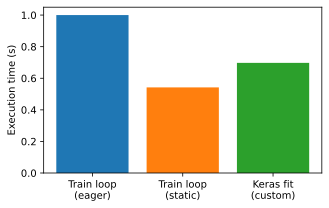

In [57]:
plt.figure(figsize=(5, 3))
plt.bar(train_times.keys(), np.array(list(train_times.values())) / max(train_times.values()), color=["C0", "C1", "C2"])
plt.ylabel("Execution time (s)");
print(f"Max execution time: {max(train_times.values())} sec.")

**Remark.** Normalized execution time. Note that `enable_op_determinism()` is not used. Results also depend on layers used.

### Regularization

Regularizers are typically penalties on layer weights and biases during optimization that constrain the network to have balanced parameters. These penalties are added to the loss value that the network optimizes. Keras layers implement the following optional regularization arguments:

* `kernel_regularizer`
* `bias_regularizer`
* `activity_regularizer`

<br>

**Keras fit.** Here we train the same network above for FMNIST. Notice that the network is unable to learn due to excessive regularization, this implies that `fit` automatically takes into account the regularization terms during training.

In [58]:
import tensorflow.keras.regularizers as regularizers

setup = reset_experiment()
train_loader = setup["train_loader"]
valid_loader = setup["valid_loader"]

model = kr.Sequential()
model.add(Dense(units=256, activation="relu", kernel_regularizer=regularizers.l2(3.0)))
model.add(Dense(units=256, activation="relu", kernel_regularizer=regularizers.l2(3.0)))
model.add(Dense(units=256, activation="relu", kernel_regularizer=regularizers.l2(3.0)))
model.add(Dense(units=10))

model.build(input_shape=(None, 784))
model.compile(
    optimizer=kr.optimizers.SGD(), 
    loss=kr.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=[
        kr.metrics.SparseCategoricalAccuracy(),
        kr.metrics.SparseTopKCategoricalAccuracy(k=3)
    ]
)
model.fit(train_loader, epochs=3, validation_data=valid_loader);

Epoch 1/3
1875/1875 [==============================] - 76s 40ms/step - loss: 14.6338 - sparse_categorical_accuracy: 0.1025 - sparse_top_k_categorical_accuracy: 0.3013 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1000 - val_sparse_top_k_categorical_accuracy: 0.3000
Epoch 2/3
1875/1875 [==============================] - 74s 39ms/step - loss: 2.3027 - sparse_categorical_accuracy: 0.0973 - sparse_top_k_categorical_accuracy: 0.2941 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1000 - val_sparse_top_k_categorical_accuracy: 0.3000
Epoch 3/3
1875/1875 [==============================] - 73s 39ms/step - loss: 2.3027 - sparse_categorical_accuracy: 0.0989 - sparse_top_k_categorical_accuracy: 0.2958 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1000 - val_sparse_top_k_categorical_accuracy: 0.3000


<br>

**Custom training.** For weight regularization in custom training steps, regularization in each layer are accumulated using `sum(self.losses)` and added to the target loss, so that the contributions are backpropagated to the weights. See also the [`add_loss()`](https://keras.io/api/losses/#the-addloss-api) method for custom layers.

In [59]:
class RegularizedModel(tf.keras.Model):
    def __init__(self, param=0.0):
        super().__init__(self)
        self.h0 = Dense(256, "relu", kernel_regularizer=regularizers.l2(param))
        self.h1 = Dense(256, "relu", kernel_regularizer=regularizers.l2(param))
        self.h2 = Dense(256, "relu", kernel_regularizer=regularizers.l2(param))
        self.h3 = Dense(10)
    
    def call(self, x, training=False):
        return self.h3(self.h2(self.h1(self.h0(x))))


    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            preds = self.call(inputs, training=True)
            loss = self.compiled_loss(targets, preds) + sum(self.losses)   # (!)
        
        # Update states
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        self.compiled_metrics.update_state(targets, preds)
        
        # Return logs
        logs = {m.name: m.result() for m in self.metrics}
        return logs
        

    def test_step(self, data):
        inputs, targets = data
        preds = self.call(inputs, training=False)

        # Update states
        self.compiled_loss(targets, preds)
        self.compiled_metrics.update_state(targets, preds)

        # Return logs
        logs = {m.name: m.result() for m in self.metrics}
        return logs


# Construct and compile an instance of CustomModel
setup = reset_experiment()
train_loader = setup["train_loader"]
valid_loader = setup["valid_loader"]

model = RegularizedModel(param=3.0)
model.build(input_shape=(None, 784))
model.compile(
    optimizer=kr.optimizers.SGD(), 
    loss=kr.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=[
        kr.metrics.SparseCategoricalAccuracy(),
        kr.metrics.SparseTopKCategoricalAccuracy(k=3)
    ]
)

model.fit(train_loader, epochs=3, validation_data=valid_loader);

Epoch 1/3
1875/1875 [==============================] - 42s 22ms/step - loss: 2.3023 - sparse_categorical_accuracy: 0.1025 - sparse_top_k_categorical_accuracy: 0.3013 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1000 - val_sparse_top_k_categorical_accuracy: 0.3000
Epoch 2/3
1875/1875 [==============================] - 41s 22ms/step - loss: 2.3027 - sparse_categorical_accuracy: 0.0973 - sparse_top_k_categorical_accuracy: 0.2941 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1000 - val_sparse_top_k_categorical_accuracy: 0.3000
Epoch 3/3
1875/1875 [==============================] - 46s 24ms/step - loss: 2.3027 - sparse_categorical_accuracy: 0.0989 - sparse_top_k_categorical_accuracy: 0.2958 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1000 - val_sparse_top_k_categorical_accuracy: 0.3000


Notice that the results using the `fit` method are reproduced except for the loss value which corresponds only to the cross entropy. This is because the loss only includes the compiled loss. Although logging regularization penalty seems to be less useful, to be totally consistent with Keras `fit` use:

```python
loss = self.compiled_loss(targets, preds, regularization_losses=self.losses)
```

---

■